**<h1> Object detection with Faster R-CNN </h1>**


Faster R-CNN is a method for object detection that uses region proposal.  In this lab, you will use Faster R-CNN pre-trained on the coco dataset. You will learn how to detect several   objects by name and to use the likelihood of the object prediction being correct.


In [2]:
! pip3 install torch==1.13.0 torchvision==0.14.0 torchaudio

In [3]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2024-03-01 06:07:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg’

DLguys.jpeg         100%[===================>]  47.43K  --.-KB/s    in 0.001s  

2024-03-01 06:07:35 (31.9 MB/s) - ‘DLguys.jpeg’ saved [48572/48572]

--2024-03-01 06:07:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s


## Import Libraries and Define Auxiliary Functions


deep-learning libraries , may have to update:


In [5]:
! conda install pytorch=1.1.0 torchvision -c pytorch -y

Retrieving notices: ...working... done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - pytorch=1.1.0
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       h06a4308_0         126 KB
    cudatoolkit-10.0.130       |                0       261.2 MB
    cudnn-7.6.5                |       cuda10.0_0       165.0 MB
    openssl-1.1.1w             |       h7f8727e_0         3.7 MB
    pytorch-1.1.0              |cuda100py37he554f03_0       196.3 MB
    torchvision-0.13.1         |cpu_py37h164cc8f_0         6.0 MB
    ------------------------------------------------------------
                                           Total:       632.4 MB

The following NEW packages will be

In [11]:
pip install --upgrade torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

libraries for getting data from the web  


In [2]:
import requests

libraries  for image processing and visualization


In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold.


In [4]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

Draws box around each object


In [5]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple 
    that corresponds to information about  the different objects; 
    Each element includes a tuple with the class name, 
    probability of belonging to that class and the coordinates 
    of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]
        
        pt1 = (int(box[0][0]), int(box[0][1]))
        pt2 = (int(box[1][0]), int(box[1][1]))
        
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, pt1,  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), pt1,  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    del(img)
    del(image)

this function will free up some memory:


In [6]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

## Load Pre-trained Faster R-CNN


<a href='https://arxiv.org/abs/1506.01497?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">COCO<a>. 


In [7]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

#model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model_.eval()

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model_ = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.5)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


the function calls Faster R-CNN <code> model_ </code> but save RAM:


In [8]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Here are the 91 classes.


In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization


In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of <a href="https://www.utoronto.ca/news/ai-fuels-boom-innovation-investment-and-jobs-canada-report-says?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01"> Geoffrey Hinton</a>


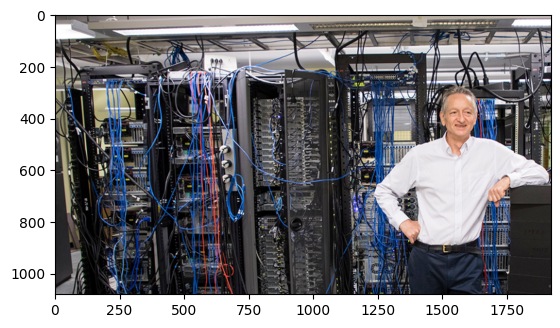

In [10]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

We will create a transform object to convert the image to a tensor.


In [11]:
transform = transforms.Compose([transforms.ToTensor()])

We convert the image to a tensor.


In [12]:
img = transform(image)

we can make a prediction,The output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.


In [13]:
pred = model([img])

<b>note</b>:  if you call <code>model_([img])</code>  directly but it will use more RAM 


In [14]:
pred[0]

{'boxes': tensor([[1243.1423,  287.3914, 1893.6095, 1063.8922]]),
 'labels': tensor([1]),
 'scores': tensor([0.9996])}

We have the likelihood of each class:


In [15]:
pred[0]['scores']

tensor([0.9996])

*Note* here we use likelihood as a synonym for probability. Many neural networks output a probability of the output of being a specific class. Here the output is the confidence of  prediction, so we use the term likelihood to distinguish between the two 


The class number corresponds to the index of the list with the corresponding  category name 


In [16]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

we have the coordinates of the bounding box


In [17]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1243.142333984375, 287.3913879394531, 1893.6094970703125, 1063.8922119140625]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :
<p>top (t),left (l),bottom(b),right (r)</p>
we need to round them


In [18]:
t,l,r,b=[round(x) for x in bounding_box]

We convert the tensor to an open CV array and plot an image with the box:


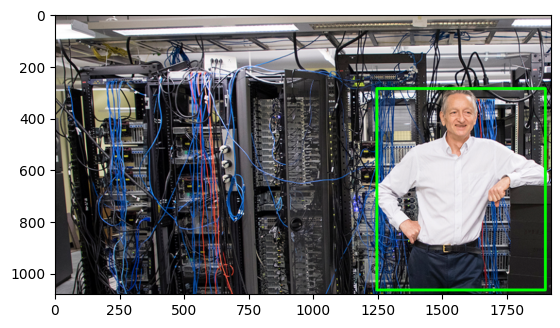

In [19]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

We can localize objects; we do this using the function 
<code>get_predictions</code>. The input  is the predictions <code>pred</code> and the <code>objects</code> you would like to localize .


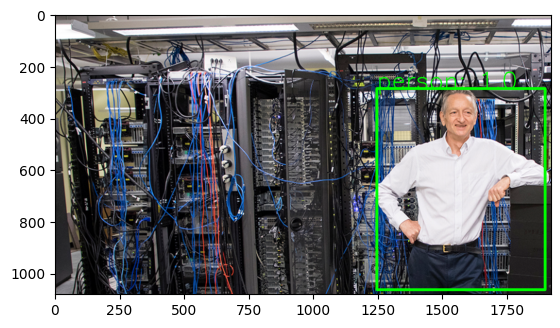

In [20]:
pred_class=get_predictions(pred,objects="person")
#print(pred_class)
draw_box(pred_class, img)
del pred_class

We can set a threshold <code>threshold </code>. Here we set the  threshold 1 i.e Here we set the  threshold 1 i.e. 100% likelihood. 


In [21]:
get_predictions(pred,threshold=1,objects="person")

[]

Here we have no output as the likelihood is not 100%.  Let's try a threshold of 0.98 and use the function  draw_box to draw the box and plot the class and it's rounded likelihood.


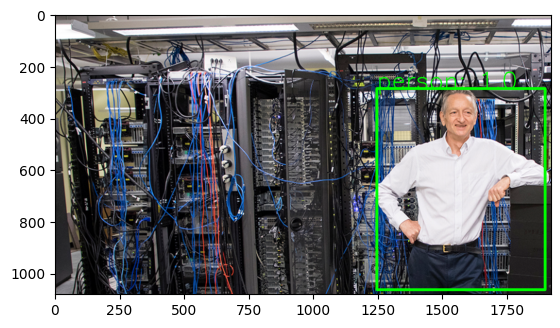

In [22]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

Delete objects to save memory, we will run this after every cell:


In [23]:
save_RAM(image_=True)

We can locate multiple objects, consider the following <a href='https://www.kdnuggets.com/2015/03/talking-machine-deep-learning-gurus-p1.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01'>image</a>, we can detect the people in the image.


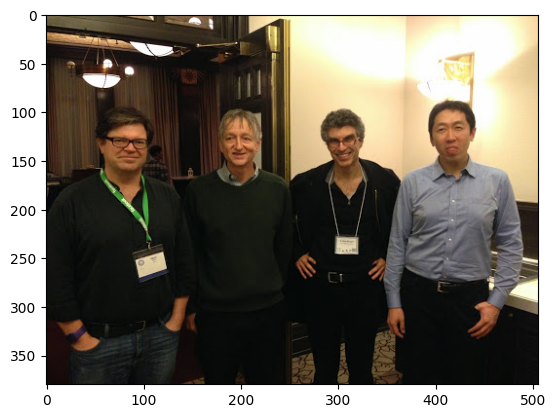

In [24]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

we can set a threshold to detect the object, 0.9 seems to work.


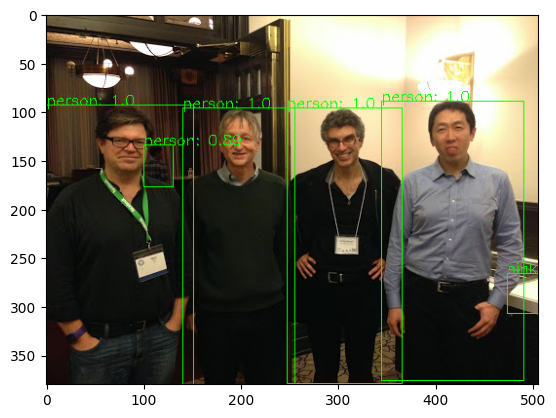

In [25]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.5,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

Or we can use objects parameter: 


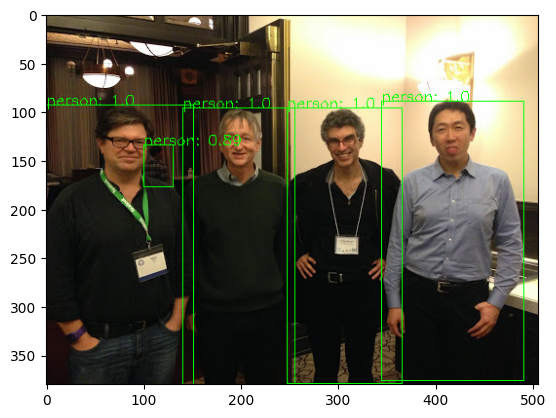

In [26]:

pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

If we set the threshold too low, we will detect objects that are not there.


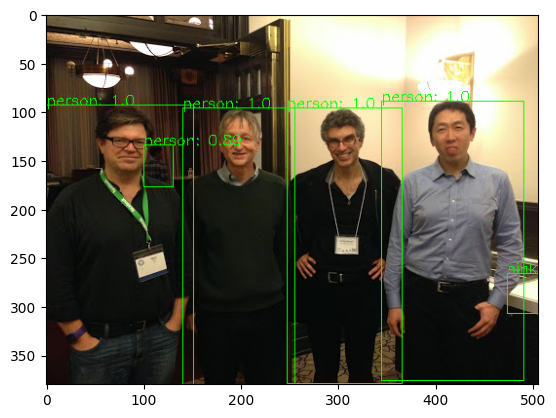

In [27]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

the following lines will speed up your code by using less RAM.


In [28]:
save_RAM(image_=True)

## Object Detection 


In Object Detection we find the classes as well detect the objects in an image. Consider the following <a href="https://www.dreamstime.com/stock-image-golden-retriever-puppy-lying-parakeet-perched-its-head-weeks-old-next-to-british-shorthair-kitten-sitting-image30336051?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">image</a>


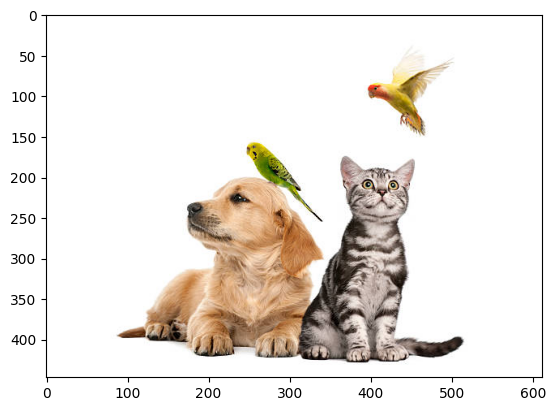

In [29]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

If we set a threshold, we can detect all objects whose likelihood is above that threshold.


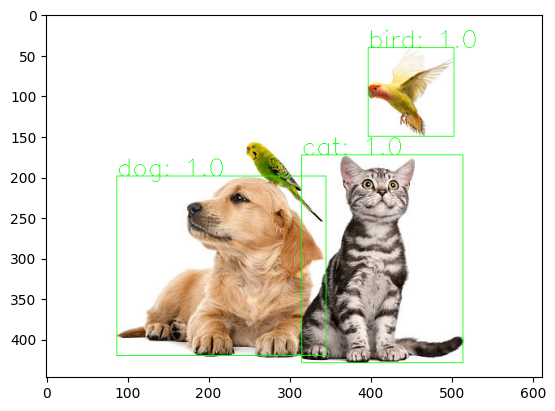

In [30]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.2)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

the following lines will speed up your code by using less RAM.


In [31]:
 save_RAM(image_=True)

We can specify the objects we would like to classify, for example, cats and dogs:


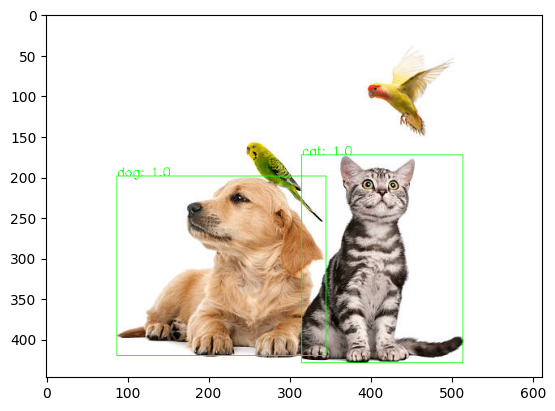

In [32]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
img = transform(image)
pred = model([img])
pred_obj=get_predictions(pred,objects=["dog","cat"])
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj



In [33]:
# save_RAM()

If we set the threshold too low, we may detect objects with a low likelihood of being correct; here, we set the threshold to 0.7, and we incorrectly  detect a cat 


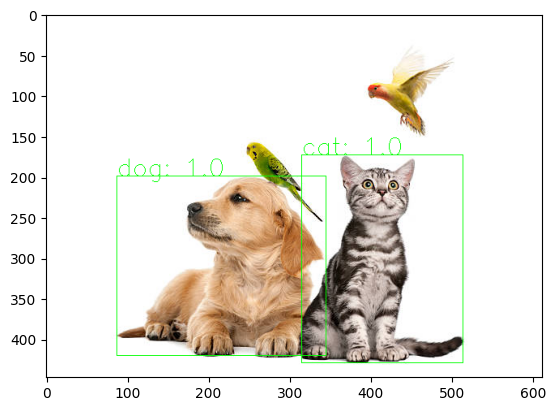

In [34]:
# img = transform(image)
#pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.70,objects=["dog","cat"])
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

In [35]:
save_RAM(image_=True)


We can detect other objects. Consider the following <a href='https://www.flickr.com/photos/watts_photos/27581126637?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01'>image</a>; We can detect cars and airplanes 


In [36]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

In [37]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.997)
draw_box(pred_thresh,img)
del pred_thresh

In [38]:
save_RAM(image_=True)

## Test Model With An Uploaded Image


You can enter the URL of an image and see if you can detect objects in it . Just remember it must have an image  extension like <code>jpg</code> or <code>png</code>.


In [51]:
url='https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'

We will perform a get request to download the image from the web and convert it to an RGB image. 


In [52]:
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

In [53]:
img = transform(image )
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

In [54]:
save_RAM(image_=True)

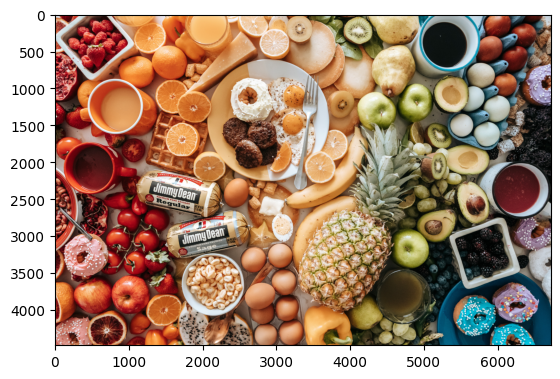

In [55]:
 img_path='23.jpg'
 image = Image.open(img_path) # Load the image
 plt.imshow(np.array(image ))
 plt.show()

detect objects 


In [56]:
img = transform(image )
pred = model(img.unsqueeze(0))
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh,img)
listit(pred_thresh)
del pred_thresh

The objects detected in the given image along with their count:
fork: 1
orange: 9
donut: 4
apple: 3
cup: 1
bowl: 1


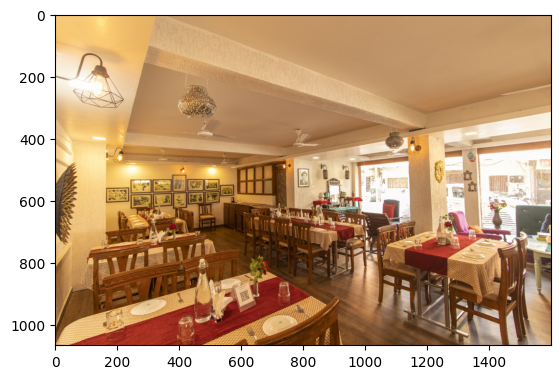

In [57]:
 img_path='27.jpg'
 image = Image.open(img_path) # Load the image
 plt.imshow(np.array(image ))
 plt.show()


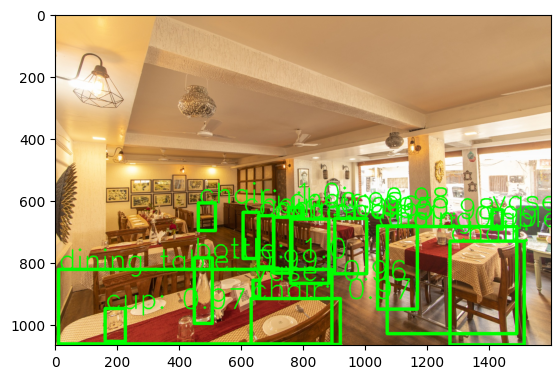

The objects detected in the given image along with their count:
chair: 10
bottle: 1
vase: 2
dining table: 2
cup: 1


In [58]:
img = transform(image )
pred = model(img.unsqueeze(0))
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh,img)
listit(pred_thresh)
del pred_thresh

In [59]:
save_RAM(image_=True)

In [60]:
def listit(pred_thresh):
    f = {}
    for i in range(len(pred_thresh)):
        if pred_thresh[i][0] not in f:
            f[pred_thresh[i][0]]=1
        else:
            f[pred_thresh[i][0]]+=1
    print("The objects detected in the given image along with their count:")
    for i in f:
        print(f"{i}: {f[i]}")